<a href="https://colab.research.google.com/github/andersonsam/pacific_northwest_heatwave/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#clone in github repo

!git clone https://github.com/andersonsam/pacific_northwest_heatwave #public repo

Cloning into 'pacific_northwest_heatwave'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 66 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [2]:
# # Here: download libraries and make requirements.txt file; only uncomment and run if not using requirements.txt on github (https://github.com/andersonsam/pacific_northwest_heatwave)
# # requirements.txt made in this way will include many dependencies that are not necessary for this project (they are standard packages in Colab)
# # The file requirements.txt at https://github.com/andersonsam/pacific_northwest_heatwave is a trimmed-down version of the file made in the lines below w/ only the necessary packages

# #download required libraries which are not in colab

# !pip install geopandas

# #create environment from downloaded libraries + colab libraries 
# !pip3 freeze > requirements.txt  # Python3

In [3]:
#install the required dependencies

!pip install -r pacific_northwest_heatwave/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 24.8 MB/s 
     |████████████████████████████████| 4.6 MB 31.1 MB/s 
     |████████████████████████████████| 15.7 MB 15.6 MB/s 
     |████████████████████████████████| 2.0 MB 8.9 MB/s 
     |████████████████████████████████| 6.3 MB 11.9 MB/s 
     |████████████████████████████████| 16.7 MB 3.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: Shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
  Attempting uninstall: netCDF4
    Found existing installation: netCDF4 1.6.2
    Uninstalling netCDF4-1.6.2:
      Successfully uninstalled netCDF4-1.6.2


#Preamble

Glaciated:  
BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER (08ME023)  
HOMATHKO RIVER AT THE MOUTH (08GD004)  
NORTH SASKATCHEWAN RIVER AT WHIRLPOOL POINT (05DA009)  

Snowy, then depleted:  
CHILLIWACK RIVER ABOVE SLESSE CREEK (08MH103)   
FRASER RIVER AT SHELLEY (08KB001)  
SKEENA RIVER AT USK (08EF001)  

Snowy, but already (or mostly) depleted:  
ELK RIVER AT FERNIE (08NK002)  
SALMO RIVER NEAR SALMO (08NE074)  
OYSTER RIVER BELOW WOODHUS CREEK (08HD011)  


In [4]:
#import required libraries

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from netCDF4 import Dataset

from datetime import datetime, date, timedelta
from google.colab import drive
from shapely.geometry import Point

dir_data = 'pacific_northwest_heatwave/Data/'

In [5]:
# #mount google drive
# drive.mount('/content/drive')

In [6]:
#define functions

def plot_prov_ax(prov, ax, linewidth = 1):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  # provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes_filename = 'pacific_northwest_heatwave/Data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if prov_poly.geom_type == 'Polygon': #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k', linewidth = linewidth)

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly.geoms)): 
        lonBorder_segment,latBorder_segment = prov_poly.geoms[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth)

# Flow data

In [7]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)

stationIDs = [
              '08ME023',
              '08GD004',
              '05DA009',
              '08MH103',
              '08KB001',
              '08EF001',
              '08NK002',
              '08NE074',
              '08HD011'
]

stationNames = [
                'BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER',
                'HOMATHKO RIVER AT THE MOUTH',
                'NORTH SASKATCHEWAN RIVER AT WHIRLPOOL POINT',
                'CHILLIWACK RIVER ABOVE SLESSE CREEK',
                'FRASER RIVER AT SHELLEY',
                'SKEENA RIVER AT USK',
                'ELK RIVER AT FERNIE',
                'SALMO RIVER NEAR SALMO',
                'OYSTER RIVER BELOW WOODHUS CREEK'
]

classes = [0,0,0,1,1,1,2,2,2] #0: highly glaciated; 1: snow at time of heatwave; 2: snow (largely) depleted by heatwave onset

filenames_2021 = [stationID + '_2021.csv' for stationID in stationIDs]
filenames_hist = [stationID + '_hist.csv' for stationID in stationIDs]

#station information
station_df = pd.read_csv(dir_data + 'station_data.csv')
stationLat = station_df['Latitude [degN]']
stationLon = station_df['Longitude [degE]']
stationArea = station_df['DrainageArea [km2]']
stationPG = station_df['Percent Glacier Cover']

#basin information
pickle_in = open(dir_data + 'stationBasins.pickle', 'rb')
stationBasins = pickle.load(pickle_in)

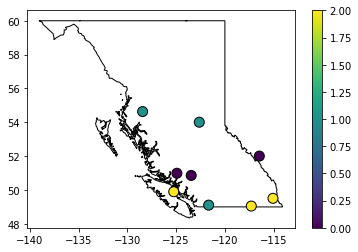

In [8]:
#visualize stations in space
fig, ax = plt.subplots()
plot_prov_ax(prov = ['BC'], ax = ax)
s = ax.scatter(stationLon, stationLat, c = classes, zOrder = 5, s = 100, edgecolor = 'k', linewidth = 1)
plt.colorbar(s)

In [9]:
##### historical flows
date_inds = np.arange(120,274) #May 1 through Oct 1
Ndays = len(date_inds)
Nstations = 9

flow_mean = np.zeros((Nstations, Ndays))
flow_median = np.zeros((Nstations, Ndays))
flow_std = np.zeros((Nstations, Ndays))
flow_q1 = np.zeros((Nstations, Ndays))
flow_q3 = np.zeros((Nstations, Ndays))

p1 = 16
p3 = 84

#calculate median historical flow, and p1 and p3 percentiles of flow over historical period
for kk in range(Nstations): #for each station

  flow_hist_all = pd.read_csv(dir_data + filenames_hist[kk], header = 1)
  flow_hist = flow_hist_all.loc[flow_hist_all['YEAR'] >= 1979]

  year_start = 1979
  year_end = flow_hist['YEAR'].iloc[-1]
  Nyears = year_end - year_start + 1
  flow_mat = np.zeros((Nyears,365))
  months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  n_days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
  for kk_year, year in enumerate(range(year_start, year_end + 1)):
    for kk_month, month in enumerate(months):
      if sum(flow_hist['YEAR']==year) > 0:
        flow = flow_hist[month][flow_hist['YEAR']==year][:n_days_per_month[kk_month]]
        flow_mat[kk_year, sum(n_days_per_month[:kk_month]) : sum(n_days_per_month[:kk_month+1])] = flow
      else:
        flow_mat[kk_year, sum(n_days_per_month[:kk_month]) : sum(n_days_per_month[:kk_month+1])] = np.nan

  flow_mat = flow_mat[:,date_inds]
  flow_mean[kk,:] = np.nanmean(flow_mat, axis = 0)
  flow_median[kk,:] = np.nanmedian(flow_mat, axis = 0)
  flow_q1[kk,:] = np.nanpercentile(flow_mat, p1, axis = 0)
  flow_q3[kk,:] = np.nanpercentile(flow_mat, p3, axis = 0)

##### calculate 2021 flows
flow_daily = np.zeros((Nstations, Ndays))
for station in range(Nstations):
  df = pd.read_csv(dir_data + filenames_2021[station], header = 7)
  flow_realtime = df['Value (m3/s)']
  date_flow = [dd[:10] for dd in df[df.columns[0]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_flow) if ee == ds])
    flow_daily[station,day] = np.nanmean(flow_realtime[inds])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


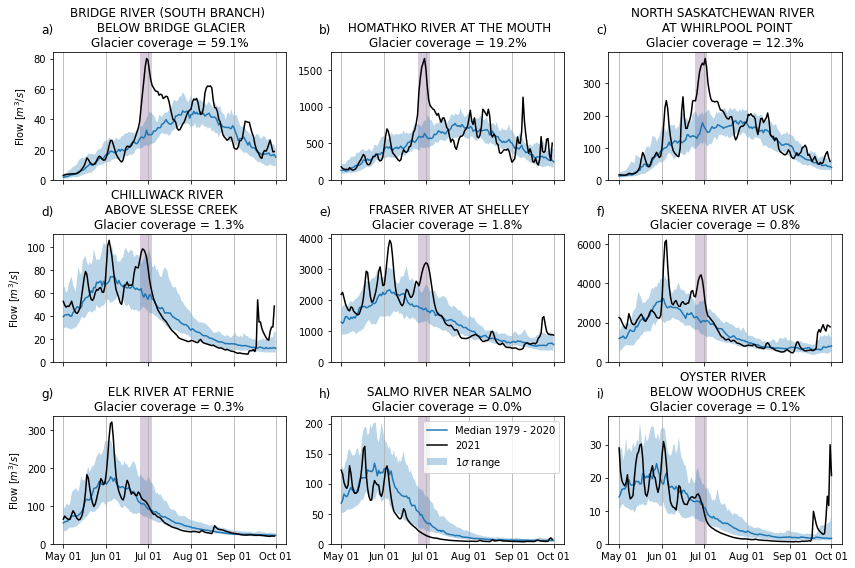

In [12]:
#visualize

fs = 12

saveIt = 0
savePDF = 0

abcs = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 25)
heat_fin = heat_start + timedelta(days = 8)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_q1[station,:]
  y2 = flow_q3[station,:]

  bottom = 0
  top = np.nanmax([flow_daily[station,:], y2])*1.05

  #heat
  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  #flow
  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1$\sigma$ range')
  ax.plot(datetimes, flow_median[station,:], label  = 'Median 1979 - 2020')
  ax.plot(datetimes, flow_daily[station,:], 'k', label = '2021')

  #format
  ax.set_ylim(bottom = bottom, top = top)
  ax.set_xticks(ax.get_xticks())#[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()
  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')

  title_breaks = [4,0,3,2,0,0,0,0,2]

  a = stationNames[station].split(' ')
  newtitle = a[:title_breaks[station]] + ['\n'] + a[title_breaks[station]:]
  ax.set_title(' '.join(newtitle) + '\nGlacier coverage = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

  if station == 7:
    ax.legend()
  if station < 6:
    ax.set_xticklabels([])
  ax.grid(True, axis = 'x')
  ax.text(x = -0.05, y = 1.15, s = abcs[station], transform = ax.transAxes, fontsize = fs)

plt.tight_layout(h_pad = 0.2)

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

if savePDF:
  plt.savefig('heat_wave_flows.pdf', dpi = 300, bbox_inches = 'tight', format = 'pdf')

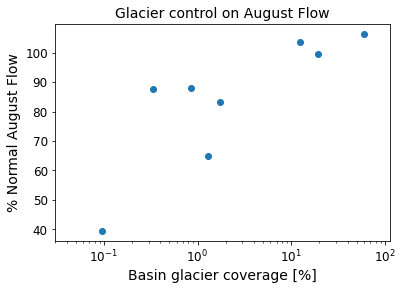

In [ ]:
saveIt = 0

fs = 14

ind_start = 75
ind_end = 135

flow_median_aug = np.sum(flow_median[:,ind_start:ind_end], axis = 1)
flow_2021_aug = np.sum(flow_daily[:,ind_start:ind_end], axis = 1)

aug_ratio = flow_2021_aug / flow_median_aug

fig, ax = plt.subplots()

ax.scatter(stationPG*100, aug_ratio*100)

ax.set_xscale('log')
ax.set_xlim(left = 0.0003*100)
ax.set_xlabel('Basin glacier coverage [%]', fontsize = fs)
ax.set_ylabel('% Normal August Flow', fontsize = fs)
ax.set_title('Glacier control on August Flow', fontsize = fs)
ax.tick_params(labelsize = fs-2)

if saveIt:
  plt.savefig('heat_wave_glacier_control_august.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# #SWE data

# #open netcdf file
# filenameERA = '/ERA5land_SWE_2021_hourly_01_grid_AB_BC.nc'
# # filenameERA = 'adaptor.mars.internal-1641406346.1239731-18004-12-6e45c83b-7b70-40a2-afda-ba88b0a6d71d.nc'
# filePathERA = dir_data + filenameERA
# ERA = Dataset(filePathERA)

# #extract data from file
# lonERA = ERA.variables['longitude'][:] #longitude in degrees W 
# latERA = ERA.variables['latitude'][:]
# hoursERA = ERA.variables['time'][:] #hours since Jan 1, 1900
# swe_hourly = ERA.variables['sd'][:] #snow water equivalent, in m

# #convert hourly data to daily averages
# timestamps_per_day = 24
# swe = []
# for daynum in range(int(len(hoursERA)/timestamps_per_day)): #for each day
#   inds = list(range(daynum*timestamps_per_day,daynum*timestamps_per_day+timestamps_per_day))
#   swe.append(np.mean(swe_hourly[inds,:,:],axis=0))

# swe = np.asarray(swe)

# sweDict = {
#   'SWE':swe,
#   'lonERA':lonERA,
#   'latERA':latERA,    
# }

In [ ]:
# saveIt = 0

# fs = 12

# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

# swe_pre = swe[174]
# swe_post = swe[182]
# swe_diff = - swe_post + swe_pre
# swe_diff = swe_post - swe_pre
# var = swe_pre

# cmap = 'Blues'
# cmap = 'terrain_r'
# extent_swe = [-142,-110,48,62]

# im = ax[0].imshow(var, aspect = 'auto', cmap = cmap, extent = extent_swe, norm=matplotlib.colors.LogNorm(), vmin = 10**-3)
# plot_prov_ax(prov,ax[0])
# s = ax[0].scatter(stationLon[stationInds], stationLat[stationInds], zOrder = 5, s = 75, edgecolor = 'k', linewidth = 1, facecolor = 'w')

# for kk, basin in enumerate(stationBasins):
#   xx,yy = basin.exterior.xy
#   ax[0].plot(xx,yy, color = 'k', linewidth = 0.75)

# ax[0].set_xlim(left = -141)
# ax[0].set_ylim(top = 61)
# ax[0].set_title('June 24 Snow water equivalent', fontsize = fs)

# cb = plt.colorbar(im, ax = ax[0])
# cb.ax.set_ylabel('SWE [m]', fontsize = fs)

# ##### glacier figure

# ind_start = 75
# ind_end = 135

# flow_median_aug = np.sum(flow_median[:,ind_start:ind_end], axis = 1)
# flow_2021_aug = np.sum(flow_daily[:,ind_start:ind_end], axis = 1)

# aug_ratio = flow_2021_aug / flow_median_aug

# ax[1].scatter(stationPG*100, aug_ratio*100)

# ax[1].set_xscale('log')
# ax[1].set_xlim(left = 0.0003*100)
# ax[1].set_xlabel('Basin glacier coverage [%]', fontsize = fs)
# ax[1].set_ylabel('% Normal August Flow', fontsize = fs)
# ax[1].set_title('Glacier control on August Flow', fontsize = fs)
# ax[1].tick_params(labelsize = fs-2)

# for kk, aa in enumerate(ax):
#   aa.text(x = -0.05, y = 1.05, s = abcs[kk], transform = aa.transAxes, fontsize = fs)

# fig.tight_layout()

# xtls = [item.get_text()[1:] + '$^\circ$W' for item in ax[0].get_xticklabels()]
# ax[0].set_xticklabels(xtls, fontsize = 10)
# ytls = [item.get_text() + '$^\circ$N' for item in ax[0].get_yticklabels()]
# ax[0].set_yticklabels(ytls, fontsize = 10)

# if saveIt:
#   plt.savefig('heat_wave_swe_glaciers.png', dpi = 300, bbox_inches = 'tight')

# plt.show()